In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                (df_sales['item_id']==20949)]
                                
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet['log_item_cnt_day_total'] = np.log(df_sales_fbprophet['item_cnt_day_total'])
df_sales_fbprophet=df_sales_fbprophet[['date','log_item_cnt_day_total']]
df_sales_fbprophet


,date,log_item_cnt_day_total
0,2013-04-24,2.079442
1,2013-04-25,3.218876
2,2013-04-26,3.761200
3,2013-04-27,3.637586
4,2013-04-28,3.637586
...,...,...
916,2015-10-27,4.304065
917,2015-10-28,4.499810
918,2015-10-29,4.521789
919,2015-10-30,4.770685


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "log_item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=df_sales_fbprophet['y'].min()
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-04-24,2.079442,2.079442,7.036148
1,2013-04-25,3.218876,2.079442,7.036148
2,2013-04-26,3.761200,2.079442,7.036148
3,2013-04-27,3.637586,2.079442,7.036148
4,2013-04-28,3.637586,2.079442,7.036148
...,...,...,...,...
916,2015-10-27,4.304065,2.079442,7.036148
917,2015-10-28,4.499810,2.079442,7.036148
918,2015-10-29,4.521789,2.079442,7.036148
919,2015-10-30,4.770685,2.079442,7.036148


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
            #growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

92

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=df_sales_fbprophet['y'].min()
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
1008,2016-01-27,2.079442,7.036148
1009,2016-01-28,2.079442,7.036148
1010,2016-01-29,2.079442,7.036148
1011,2016-01-30,2.079442,7.036148
1012,2016-01-31,2.079442,7.036148


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1008,2016-01-27,3.789674,3.323123,4.218972
1009,2016-01-28,3.866238,3.441252,4.319648
1010,2016-01-29,4.186699,3.742851,4.633773
1011,2016-01-30,4.583422,4.156415,5.032126
1012,2016-01-31,4.292743,3.855404,4.714432


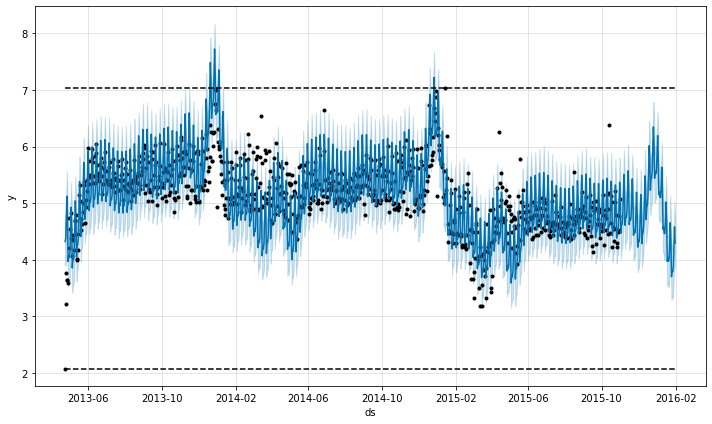

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'])

921    160.705852
922     87.319143
923    101.640397
924    101.960761
925    113.257557
926    161.088842
927    246.777400
928    185.167276
929    100.500694
930    116.139986
931    115.225113
932    126.035309
933    175.733039
934    262.939251
935    192.468928
936    101.744044
937    114.088633
938    109.760187
939    116.362210
940    157.247504
941    228.324737
942    162.868661
943     84.237344
944     92.604029
945     87.786201
946     92.168519
947    123.994511
948    180.319844
949    129.902364
950     68.359932
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()

4096.728270512381